# The Metropolis-Hastings Algorithm

In almost every subject, analytics alone can only take you so far. Using numerical methods can answer many question about analytically intractable systems. In addition, numerics can help check the validity of analytical results without needing to do an experiment and provide complete control over model parameters. This notebook demonstrates how to use the most common numerical technique in statistical mechanics called the Metropolis-Hastings algorithm, named after Nicholas Metropolis and W.K. Hastings. __This algorithm lets you sample from the equilibrium distribution of states at a given temperature.__ It works across a wide variety of systems and is simple to implement.

- You begin by coming up with a representation for states of the system of interest in computer memory.  For example, states of the 2D Ising model on a square lattice can be represented by a 2D array of numbers where 1 represents an up facing spin at that lattice site and -1 represents a down facing spin.  You should also have some way of plotting the states so you can see what they look like.
- Next you need a energy function which takes a state of the system and outputs its energy.
- The algorithm works iteratively. You initialize the state of the system to any random state, and begin doing Metropolis steps.  Each step you:
    - Calculate the energy of the current state of the system. Call it state A.
    - Consider a different state of the system (say by flipping one spin) and calculate the energy of that other state. Call it state B.
        * If $E[A] > E[B]$, set the current state of the system to state B.
        * If $E[A] < E[B]$, you randomly choose whether the system will change to state B or stay in state A.
The probability of changing to state B is $$P(A \rightarrow B)=e^{-\frac{E[B]-E[A]}{k_B T}}$$ where T is the temperature of the system and $k_B$ is Boltzmann's constant. We choose this probability because it matches the detailed balance condition for our thermal ensemble. I will talk more about this later.
- You run this loop until the system "converges." By converge, I mean the macroscopic quantities of interest (like total energy and magnetization) stop changing by significant amounts. Of course, the random nature of the algorithm dictates that these quantities will always vary to some degree.

__Warning:__ Metropolis algorithm steps are not time. The evolution of the Metropolis algorithm does not directly correspond to the evolution of the physical system. The algorithm steps sample from the same statistical ensemble. Each step can be thought of as looking at different snap shots of the system, but not nessarily occuring one after another. Measuring the statistical properties of these snap shots, is the purpose of the metropolis algorithm.

I will explain why this algorithm works at the end of this notebook. For right now, I want you to understand what the algorithm is by implementing it in two example systems.  The 1D and the 2D ising model.

# Metropolis for the 1D Ising Model

Let's start with a simple example using the 1D Ising model

In [1]:
import numpy as np # This is numpy, a math package for python. https://numpy.org/
import matplotlib.pyplot as plt # This is matplotlib, a plotting package for python. https://matplotlib.org/

# The 1D ising model is chain of spins. Each spin can only be in one of two states, facing up (+1) or facing down (-1).
# We can represent the state of the system using a vector of N spins
N = 20
spins = np.ones(N) # This function creates a 1D array with N up spins.

print(spins) # We can print it out.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


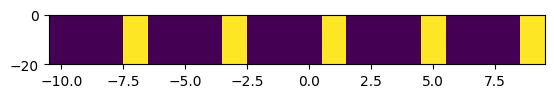

In [ ]:
# We want to be able to view our array of spins in a visually intuitive way.
# For this reason, we should make a plotting function.
def show_spins(spins, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    N = spins.shape[0] # This finds the number of spins based on the shape of the vector
    x = np.arange(-0.5*N-0.5, 0.5*N+0.5,1.)
    y = np.arange(-N,N,N)
    ax.set_aspect(0.1)
    ax.pcolormesh(x, y, np.array([spins])) # Displays a 2D color graph where blue represent a down spin and yellow represents an up spin

show_spins(2*np.floor(np.arange(20)%4/3)-1)

## Exercise 1
Make an array of spins in the highest energy state of the zero field Ising model and plot it.

As refresher the energy function of the zero field Ising model is $$E(S_i) = -J \sum_{i=1}^{N-1} S_i S_{i+1}$$ where J is positive.

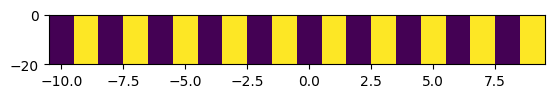

In [ ]:
# plot your spin state
# Each term in the energy is -J if neighbouring spins match
# and +J if neighbouring spins do not match. So,
# the highest energy state is spins alternating up and down.
highest_spin_state = 2*np.floor(np.arange(20)%2)-1
show_spins(highest_spin_state)

In [ ]:
def ising_model_energy(spins, J, h):
    N = spins.shape[0]
    nn_coupling = np.dot(spins[:N-1],spins[1:]) # takes the dot product of two vectors
    onsite = np.sum(spins) # takes the sum of a vectors coordinates
    return -J*nn_coupling - h*onsite

In [ ]:
# Now the algorithm proper
N = 200
curr_state = 2*np.floor(2*np.random.rand(N)) - 1.
new_state = np.zeros(N)
steps = 1000
J = 1.0
h=0.0
T=1.0

energy_record = np.zeros(steps)
magnetization = np.zeros(steps)

for i in range(steps):
    energy_record[i] = ising_model_energy(curr_state,J,h)
    magnetization[i] = np.sum(curr_state)
    for spin in range(N):
        new_state = np.copy(curr_state)
        new_state[spin] = -new_state[spin]
        dE = ising_model_energy(new_state,J,h) - ising_model_energy(curr_state,J,h)
        if np.exp(-dE/T) > np.random.rand(1):
            curr_state = new_state
            # print(dE)


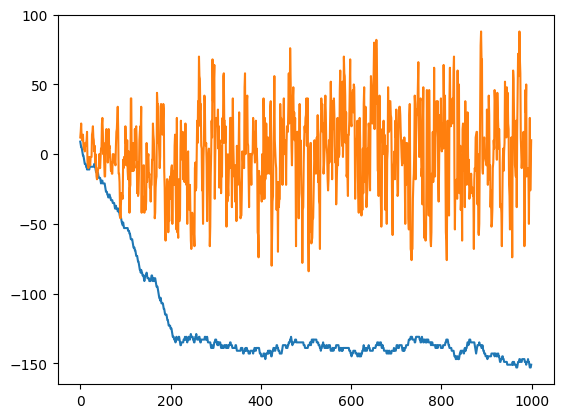

In [ ]:
plt.plot(energy_record)
plt.plot(magnetization)

## Exercise 2
Modify the code above to plot the magnetization in addition to the total energy.

__See above.__

## Exercise 3
Calculate the standard deviation of the magnetization after algorithm has converged. How does this relate to the susceptibility of the magnet?

# Answer 3
You can calculate the moments of the magnetization using the partition function:
$$
\begin{align}
H = -J \sum_{i} s_j s_{j+1} - h \sum_j s_j \\
Z(\beta, h+u) = \sum_{\mu} e^{\beta J \sum_{i} s_j s_{j+1} + \beta (h+ u) \sum_j s_j}\\
\text{Now expand the u term in the exponential} \\
Z(\beta, h+u) = \sum_{\mu} e^{-\beta H[\mu]}\sum_{n=0}^N \frac{(\beta u \sum_j s_j)^n}{n!} \\
Z(\beta, h+u) = \sum_{n=1}^N \frac{(\beta u)^n}{n!} \sum_{\mu} e^{-\beta H[\mu]}(\sum_j s_j)^n \\
Z(\beta, h+u) = Z(\beta, h) \sum_{n=1}^N \frac{(\beta u)^n}{n!} \langle (\sum_j s_j)^n\rangle \\
Z(\beta, h+u) = Z(\beta, h) \sum_{n=1}^N \frac{(\beta u)^n}{n!} \langle M^n\rangle
\end{align}
$$
which leads to the equality
$$
\langle M^n\rangle = \frac{1}{\beta^n Z(\beta, h)} \frac{d^n Z(\beta, u)}{du^n}|_{u=h}
$$

The suseptability is the derivative of the average magnetization with respect to the applied magnetic field h.
$$
\begin{align}
\beta \frac{d\langle M \rangle(u)}{du}|_{u=h} = \frac{1}{Z(\beta, u)} \frac{d^2 Z(\beta, u)}{du^2} - \frac{dZ/du}{Z^2}\frac{dZ}{du} \\
\beta \frac{d\langle M \rangle(u)}{du}|_{u=h} = \frac{1}{Z(\beta, u)} \frac{d^2 Z(\beta, u)}{du^2} - (\frac{1}{Z(\beta, h)}\frac{dZ(\beta, u)}{du}|_{u=h})^2 \\
\frac{d\langle M \rangle(u)}{du}|_{u=h}  = \beta(\langle M^2 \rangle - \langle M \rangle^2)
\end{align}
$$

So, the suseptability of the magnet is the variancy of the magnetization, the square of the standard diviation, times beta, which is one over the tempurature.

In [ ]:
suseptability = ((np.std(magnetization[400:]))**2)/T
# I only take the magnetization after 400 so the simulation had time to converge.
print(suseptability)
# This suseptability is not normilized by the number of sites. The definition of
# both suseptability and magnetization are usally given per unit volume but the
# unnormalized version is equally valid. So, it would have also been correct to
# write:
print(suseptability/N)

2437.9918222222223
12.189959111111111


## Exercise 4
Using the code above as a jumping off point, program a Metropolis simulation of the 2D ising model. Record the energy and the magnetization of the model.



In [ ]:
# create a plotting function
def show_spins2D(spins, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    N = spins.shape[0] # This finds the number of spins based on the shape of the vector
    x = np.arange(-N*0.5,N*0.5,1)
    y = np.arange(-N*0.5,N*0.5,1)
    ax.pcolormesh(x, y, spins) # Displays a 2D color graph where blue represent a down spin and yellow represents an up spin

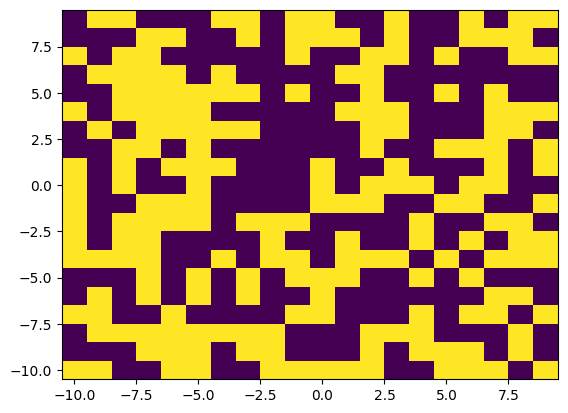

In [ ]:
show_spins2D(2*np.floor(2*np.random.rand(20,20))-1)

In [2]:
# create an energy function
def ising2D_energy(spins, J, h):
    N = spins.shape[0]
    nnx_coupling = np.einsum("ij,ij->", spins[:N-1,:],spins[1:,:])
    nny_coupling = np.einsum("ij,ij->", spins[:,:N-1],spins[:,1:])
    onsite = np.sum(spins) # takes the sum of a vectors coordinates

    return -J*(nnx_coupling + nny_coupling) - h*onsite

In [3]:
# run the metropolis algorithm
N = 200
curr_state = 2*np.floor(2*np.random.rand(N,N)) - 1.
new_state = np.zeros((N,N))
steps = 100
J = 1.0
h=0.0
T=1.0

energy_record = np.zeros(steps)
magnetization = np.zeros(steps)

for i in range(steps):
    energy_record[i] = ising2D_energy(curr_state,J,h)
    magnetization[i] = np.sum(curr_state)

    # a= int(np.floor(N*np.random.rand()))
    # b= int(np.floor(N*np.random.rand()))
    for a in range(N):
      for b in range(N):
        new_state = np.copy(curr_state)
        new_state[a,b] = -new_state[a,b]
        dE = ising2D_energy(new_state,J,h) - ising2D_energy(curr_state,J,h)
        if np.exp(-dE/T) > np.random.rand(1):
            curr_state = new_state
            # print(dE)


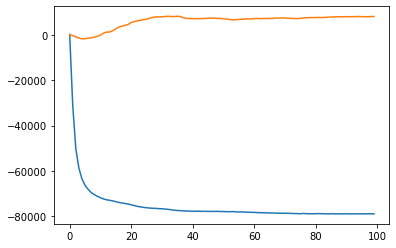

In [4]:
plt.plot(energy_record)
plt.plot(magnetization)

## Exercise 5
Using your simulation, estimate numerically the critical temperature for the 2D Ising model.

# Answer 5: How to correctly estimate the critical tempurature

Firstly, I did not expect any of you to do what I am about to do since I didn't get to talk about it in discussion section. When running one of these simulations, you can only include a finite number of sites. That means the statistical ensemble you are sampling from is not the same as the ensemble for the infinite sized system. The way to correct for this is to use an observable which scales very weakly with the size of the system.

$$B = (1 - \frac{\langle M^4 \rangle}{3 \langle M^2 \rangle^2})$$

this is called the Binder cumuluant (or parameter). This varible has the incredible property that its leading order dependence on the system size goes to zero at the critical tempurature. This means at the critical tempurautre the binder cumulant at all system sizes should be approximately the same. To use this fact, check the Binder cumulant at several system sizes and tempuratures to see at which tempurature the Binder cumuluant stays fixed across system sizes. The point at which all large system size have the same binder cumulant is the critical tempurature.

In [18]:
def calculate_binder_at(N, T, steps = None, J = 1.0, h=0.0):
  if steps is None:
    steps = 10000
  curr_state = 2*np.floor(2*np.random.rand(N,N)) - 1.
  new_state = np.zeros((N,N))

  magnetization = np.zeros(steps*N**2)

  for i in range(steps):
    for a in range(N):
      for b in range(N):
        magnetization[(N**2)*i+a*N+b] = np.sum(curr_state)
        new_state = np.copy(curr_state)
        new_state[a,b] = -new_state[a,b]
        dE = ising2D_energy(new_state,J,h) - ising2D_energy(curr_state,J,h)
        if np.exp(-dE/T) > np.random.rand(1):
            curr_state = new_state
            # print(dE)
  return 1 - np.mean(np.power(magnetization,4))/(3*np.mean(np.power(magnetization,2))**2)

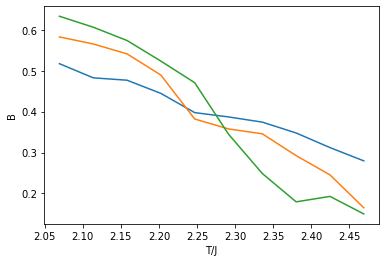

In [19]:
Ts = np.linspace(-0.2,0.2,10) + 2/(np.log(1+np.sqrt(2)))
Ns = [10, 20, 30]
for N in Ns:
    binders = np.zeros(Ts.shape[0])
    for i in range(Ts.shape[0]):
        binders[i] = calculate_binder_at(N, Ts[i])
    plt.plot(Ts, binders, label=f"N={N}")
    plt.xlabel("T/J")
    plt.ylabel("B")

As you can see, to get a good answer we would need to run some more tempuratures and some larger system sizes, which would take a lot of time. Note that this pitful looking graph already took 80+ minutes of CPU time to create. For this reason groups like the Janus Collaboration build dedicated super-computers and run nothing but Metropolis algorithms on them. __Based on the three intersections on the graph above, we can say $2.24 < T_c/J < 2.29$.__ From the exact solutions to the 2D Ising model we know:
$$T_c/J = \frac{2}{ln(1+\sqrt{2})} = 2.27$$
So, this gave us an estimate correct to with in $1.3\%$.

# Why does it work? - Detailed Balance and Markov Chains

In a Gibbs distribution, the probability of observing a given state is $$P(s) = \frac{e^{-\frac{H(s)}{k_B T}}}{Z}$$ where Z is the partition function. So, knowing the probability of finding a given state involves knowing the partition function for the system, which is usally difficult to calculate. On the other hand, $ZP(s)$, a scalar multiple of the probability distribution, is quite easy to calculate. All you need to know is the energy of a given state. __The metropolis algorithm is able to use a scalar multiple of a probability density function to sample from the distribution.__ It does this by creating a Markov Chain who's equilibrium distribution matches the relative probabilites of the distribution. For the Gibbs distribution
$$\frac{P(B)}{P(A)} = e^{-\frac{(H(A)-H(B))}{k_B T}}$$
If we then create an Markov chain where,
$$\frac{P(A \rightarrow B)}{P(B \rightarrow A)} = \frac{P(B)}{P(A)}$$
then probability of finding A vs B on given time step will match the ratio on the right hand side (given that Markov chain converges to a single distribution). This condition is called Detailed Balance.
# What is a Markov Chain?
A Markov Chain is state machine which randomly flips between states according to spesified probabilites. You can imagine states as nodes on a graph show the probability of a transition using edges. Let's look at some simple examples:

{('Up', 'Down'): Text(-1.1102230246251565e-16, 0.0, '0.5'),
 ('Down', 'Up'): Text(-1.1102230246251565e-16, 0.0, '0.5')}

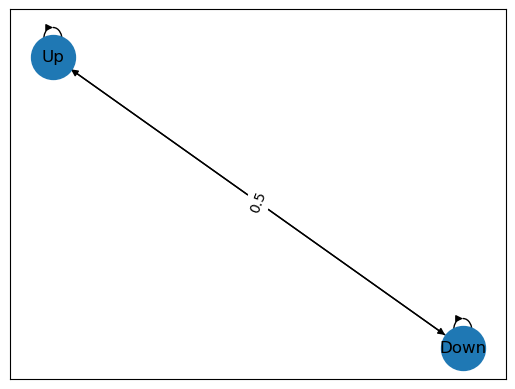

In [ ]:
import networkx as nx # This package lets me display node-edge graphs https://networkx.org/
G = nx.DiGraph()
G.add_node('Up')
G.add_node('Down')
G.add_edge('Up', 'Down')
G.add_edge('Up', 'Up')
G.add_edge('Down', 'Down')
G.add_edge("Down", "Up")
pos = nx.spring_layout(G)
nx.draw_networkx(G, node_size=1000)
nx.draw_networkx_edge_labels(G, pos,edge_labels={('Up', 'Down'):0.5, ('Down', 'Up'):0.5})

The example chain above randomly flips between Up and Down. At each step, it has a 1/2 chance of changing its state.  Suppose I wanted to describe the probability of a certain state occurring after n time steps and I know that the system started in the Up state. At each step, I can represent the probability distribution of the states using a 2D vector, where the first coordinate is the probability of being Up and the second is the probability of being down.
$$\vec{p} = \begin{pmatrix} p_{Up} \\ p_{Down} \end{pmatrix} $$
If I know the probabilities at step n-1, I can calculate the probability of being in the up state at step n by summing over the way the system can end in the up state:
$$p_{Up}(n) = 0.5 p_{Up}(n-1) + 0.5 p_{Down}(n-1)$$
Therefore, the probability vector at step n is just the probability vector at step n-1 times "the transition matrix" which encodes the probability of changing between states. The column represents the state you start in and the row represents the state you end up in.
$$\vec{p}(n) = \begin{pmatrix}0.5 & 0.5 \\ 0.5 & 0.5 \end{pmatrix} \vec{p}(n-1)$$
Using the recursive formula above, I can find an explicit formula for the probability distribution at the nth step:
$$p(n) = \begin{pmatrix}0.5 & 0.5 \\ 0.5 & 0.5 \end{pmatrix}^n \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$

If I now diagonalize this matrix, the formula becomes quite simple. For $n>0$:
$$p(n) = \frac{1}{2}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix}1^n & 0 \\ 0 & 0^n \end{pmatrix} \begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix}0.5 & 0.5 \\ 0.5 & 0.5 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} 1/2 \\ 1/2 \end{pmatrix}$$

NOTE: If you plug any valid initial state into the matrix above, it results in the same nth probability distribution. For other transition matrices, this will not be true at finite n, but in many cases it will be true if you take the limit as n goes to infinity.

## Exercise 6
Suppose there was a 100% chance of switching from up to down and 20% chance of switching from down to up.  Write the transition matrix.

# Answer 6

The thing to realize here is that the state of the system needs to end up somewhere at the next time step, so the probability in one column of the transition matrix better add up to 1. I gave you the elements off the diagonal, by subtracting 1 from them I can get the diagonal elements:
$$
T = \begin{pmatrix}
0 & 0.8 \\
1.0 & 0.2 
\end{pmatrix}
$$

## Exercise 7
Calculate distribution at the nth step if you start in the up state.  What is the limit as n goes to infinity? Is it dependent on the initial state?

# Answer 7
First, I diagonalize the transition matrix using the charaterisitic equation
$$
0 = p(\lambda) = \begin{vmatrix}
-\lambda & 0.8 \\
1.0 & 0.2 -\lambda
\end{vmatrix} = \lambda^2 - 0.2 \lambda - 0.8
$$
$$
0 = 5\lambda^2 - \lambda - 4
$$
$$
\lambda = \frac{1 \pm \sqrt{1 - 4*(-4)*5}}{2*5} = \frac{1}{10} \pm \frac{\sqrt{81}}{10} = 1 \text{ or} -\frac{4}{5}
$$
So, this leads to:
$$
S = \begin{pmatrix}
-1 & 4/5 \\
1 & 1
\end{pmatrix}
$$
$$
D = \begin{pmatrix}
-4/5 & 0 \\
0 & 1
\end{pmatrix}
$$
$$
S^{-1} = \frac{-5}{9} \begin{pmatrix}
1 & -4/5 \\
1 & -1
\end{pmatrix}
$$
$$T^n = S D^n S^{-1}$$
$$T^n \begin{pmatrix}
1 \\
0 
\end{pmatrix} = \begin{pmatrix}
\frac{4}{9}+\frac{5}{9}(-\frac{4}{5})^n \\
\frac{5}{9}-\frac{5}{9}(-\frac{4}{5})^n
\end{pmatrix}$$
Finally,
$$lim_{n \rightarrow \infty}T^n \begin{pmatrix}
1 \\
0 
\end{pmatrix} = \begin{pmatrix}
\frac{4}{9} \\
\frac{5}{9}
\end{pmatrix}$$

This distribution is independent of intial state.

## Exercise 8
What is significance of the eigenvalues of the transition matrix? Specifically, I want to know when the nth state will converge to a single distribution regardless of the initial state.

# Answer 8
The largest absolute value eigenvalue of the matrix T determines its limit at infinity. In order for T^n to converge, the limit of all $\lambda_j^N$ need to converge, which means $\lambda_j \leq 1$. For $T^n v$ to converge to a single distribution, only one eigenvalue can converge to something non-zero, otherwise there would be a two or more dimensional space of final distributions. This only happens if there is one $\lambda_i = 1$ and all other $|\lambda_j| < 1$. The distribution will then converge to the eigenvector assosited with eigenvalue 1.

## Exercise 9
1. Assume the powers of the transition matrix converge to a single distribution regardless of the initial state (you may use the eigenvalue the property that you found above).
2. Assume that the tranisition matrix is Metropolis matrix, meaning it was constructed to satify the detail balence condition for some distribution.

Prove the limit satifies the detailed balance condition.
$$\frac{P(A \rightarrow B)}{P(B \rightarrow A)} = \frac{P_{\infty}(B)}{P_{\infty}(A)}$$


# Answer 9

Using what we found in exercise 8 and assumption 1, we know that T has a single eigenvalue of 1 and that its eigenvector is the limit distribution. By assumption 2, we know that there is a distribution which satisfies detailed balence. If we then prove that the distribution that satifies detailed balance has eigenvalue 1, then it must be the limit distribution. Therefore, the limit distribution satifies detailed balence. Let $P_0(i)$ be the distribution that satifies detailed balence for the transfer matrix.
$$\frac{P(A \rightarrow B)}{P(B \rightarrow A)} = \frac{P_{0}(B)}{P_{0}(A)}$$
$$P(A \rightarrow B)P_{0}(A) = P(B \rightarrow A)P_{0}(B)$$
Mapping this distribution through the transition matrix:
$$\vec{v}_j = \sum_{i} P(i \rightarrow j)P_{0}(i) = \sum_{i} P(j \rightarrow i)P_{0}(j) = P_{0}(j) \sum_{i} P(j \rightarrow i)$$
Since the total probability of all possible next states must add up to one:
$$P_{0}(j) \sum_{i} P(j \rightarrow i) = P_{0}(j)$$

Therefore, $P_0(j) = \sum_{i} P(i \rightarrow j)P_{0}(i)$. So, $P_0$ has an eigenvalue of 1, which means it is  the limiting distribution. Therefore,

$$\frac{P_{\infty}(B)}{P_{\infty}(A)} = \frac{P_{0}(B)}{P_{0}(A)} = \frac{P(A \rightarrow B)}{P(B \rightarrow A)}$$

So, if the Metropolis-Hastings Algorithm converges to a single distribution, then that distribution must be the Boltzmann distribution, since the Boltzmann distribution satifies the detailed balence condition. There is actually an even stronger statement you can prove which shows that if the Markov chain is ergodic (which just means it is possible to get from one state to any other in a finite number of steps) and satifies the detailed balence condition for some distribution, then it must converge uniquely to that distribution.